In [1]:
%matplotlib inline
import numpy as np
from quantecon import LQ
from quantecon.matrix_eqn import solve_discrete_lyapunov
from scipy.optimize import root


def computeG(A0, A1, d, Q0, tau0, beta, mu):
    """
    Compute government income given mu and return tax revenues and
    policy matrixes for the planner.

    Parameters
    ----------
    A0 : float
        A constant parameter for the inverse demand function
    A1 : float
        A constant parameter for the inverse demand function
    d : float
        A constant parameter for quadratic adjustment cost of production
    Q0 : float
        An initial condition for production
    tau0 : float
        An initial condition for taxes
    beta : float
        A constant parameter for discounting
    mu : float
        Lagrange multiplier

    Returns
    -------
    T0 : array(float)
        Present discounted value of government spending
    A : array(float)
        One of the transition matrices for the states
    B : array(float)
        Another transition matrix for the states
    F : array(float)
        Policy rule matrix
    P : array(float)
        Value function matrix
    """
    # Create Matrices for solving Ramsey problem
    R = np.array([[0, -A0/2, 0, 0],
                 [-A0/2, A1/2, -mu/2, 0],
                 [0, -mu/2, 0, 0],
                 [0, 0, 0, d/2]])

    A = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 1],
                 [0, 0, 0, 0],
                 [-A0/d, A1/d, 0, A1/d+1/beta]])

    B = np.array([0, 0, 1, 1/d]).reshape(-1, 1)

    Q = 0

    # Use LQ to solve the Ramsey Problem.
    lq = LQ(Q, -R, A, B, beta=beta)
    P, F, d = lq.stationary_values()

    # Need y_0 to compute government tax revenue.
    P21 = P[3, :3]
    P22 = P[3, 3]
    z0 = np.array([1, Q0, tau0]).reshape(-1, 1)
    u0 = -P22**(-1) * P21.dot(z0)
    y0 = np.vstack([z0, u0])

    # Define A_F and S matricies
    AF = A - B.dot(F)
    S = np.array([0, 1, 0, 0]).reshape(-1, 1).dot(np.array([[0, 0, 1, 0]]))

    # Solves equation (25)
    temp = beta * AF.T.dot(S).dot(AF)
    Omega = solve_discrete_lyapunov(np.sqrt(beta) * AF.T, temp)
    T0 = y0.T.dot(Omega).dot(y0)

    return T0, A, B, F, P


# == Primitives == #
T    = 20
A0   = 100.0
A1   = 0.05
d    = 0.20
beta = 0.95

# == Initial conditions == #
mu0  = 0.0025
Q0   = 1000.0
tau0 = 0.0


def gg(mu):
    """
    Computes the tax revenues for the government given Lagrangian
    multiplier mu.
    """
    return computeG(A0, A1, d, Q0, tau0, beta, mu)

# == Solve the Ramsey problem and associated government revenue == #
G0, A, B, F, P = gg(mu0)

# == Compute the optimal u0 == #
P21 = P[3, :3]
P22 = P[3, 3]
z0 = np.array([1, Q0, tau0]).reshape(-1, 1)
u0 = -P22**(-1) * P21.dot(z0)


# == Initialize vectors == #
y = np.zeros((4, T))
uhat       = np.zeros(T)
uhatdif    = np.zeros(T)
tauhat     = np.zeros(T)
tauhatdif  = np.zeros(T-1)
mu         = np.zeros(T)
G          = np.zeros(T)
GPay       = np.zeros(T)

# == Initial conditions == #
G[0] = G0
mu[0] = mu0
uhatdif[0] = 0
uhat[0] = u0
y[:, 0] = np.vstack([z0, u0]).flatten()

for t in range(1, T):
    # Iterate government policy
    y[:, t] = (A-B.dot(F)).dot(y[:, t-1])

    # update G
    G[t] = (G[t-1] - beta*y[1, t]*y[2, t])/beta
    GPay[t] = beta*y[1, t]*y[2, t]

    # Compute the mu if the government were able to reset its plan
    # ff is the tax revenues the government would receive if they reset the
    # plan with Lagrange multiplier mu minus current G

    ff = lambda mu: (gg(mu)[0]-G[t]).flatten()

    # find ff = 0
    mu[t] = root(ff, mu[t-1]).x
    temp, Atemp, Btemp, Ftemp, Ptemp = gg(mu[t])

    # Compute alternative decisions
    P21temp = Ptemp[3, :3]
    P22temp = P[3, 3]
    uhat[t] = -P22temp**(-1)*P21temp.dot(y[:3, t])

    yhat = (Atemp-Btemp.dot(Ftemp)).dot(np.hstack([y[0:3, t-1], uhat[t-1]]))
    tauhat[t] = yhat[3]
    tauhatdif[t-1] = tauhat[t]-y[3, t]
    uhatdif[t] = uhat[t]-y[3, t]


if __name__ == '__main__':
    print("1 Q tau u")
    print(y)
    print("-F")
    print(-F)

1 Q tau u
[[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  1.00000000e+03   1.36766847e+03   1.60046731e+03   1.74687937e+03
    1.83896097e+03   1.89687301e+03   1.93329511e+03   1.95620172e+03
    1.97060817e+03   1.97966869e+03   1.98536704e+03   1.98895085e+03
    1.99120478e+03   1.99262233e+03   1.99351385e+03   1.99407455e+03
    1.99442718e+03   1.99464896e+03   1.99478845e+03   1.99487617e+03]
 [  0.00000000e+00   7.72456008e-01   2.48762974e-01   2.48761047e-01
    2.48759815e-01   2.48759040e-01   2.48758553e-01   2.48758247e-01
    2.48758054e-01   2.48757933e-01   2.48757856e-01   2.48757808e-01
    2.48757778e-01   2.48757759e-01   2.48757747e-01   2.48757740e-01
    2.48

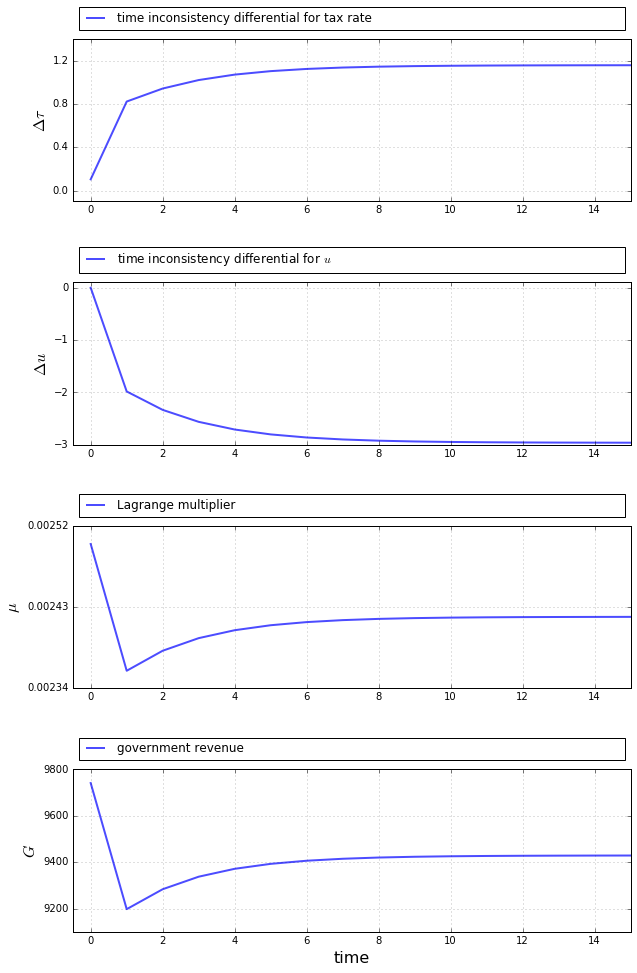

In [3]:
"""
Plot 2 from the Evans Sargent model.

@author: David Evans
Edited by: John Stachurski

"""
import numpy as np
import matplotlib.pyplot as plt

tt = np.arange(T)  # tt is used to make the plot time index correct.
tt2 = np.arange(T-1)

n_rows = 4
fig, axes = plt.subplots(n_rows, 1, figsize=(10, 16))

plt.subplots_adjust(hspace=0.5)
for ax in axes:
    ax.grid(alpha=.5)
    ax.set_xlim(-0.5, 15)

bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

ax = axes[0]
ax.plot(tt2, tauhatdif, label=r'time inconsistency differential for tax rate',
        **p_args)
ax.set_ylabel(r"$\Delta\tau$", fontsize=16)
ax.set_ylim(-0.1, 1.4)
ax.set_yticks((0.0, 0.4, 0.8, 1.2))
ax.legend(ncol=1, **legend_args)

ax = axes[1]
ax.plot(tt, uhatdif, label=r'time inconsistency differential for $u$',
        **p_args)
ax.set_ylabel(r"$\Delta u$", fontsize=16)
ax.set_ylim(-3, .1)
ax.set_yticks((-3.0, -2.0, -1.0, 0.0))
ax.legend(ncol=1, **legend_args)

ax = axes[2]
ax.plot(tt, mu, label='Lagrange multiplier', **p_args)
ax.set_ylabel(r"$\mu$", fontsize=16)
ax.set_ylim(2.34e-3, 2.52e-3)
ax.set_yticks((2.34e-3, 2.43e-3, 2.52e-3))
ax.legend(ncol=1, **legend_args)

ax = axes[3]
ax.plot(tt, G, label='government revenue', **p_args)
ax.set_ylabel(r"$G$", fontsize=16)
ax.set_ylim(9100, 9800)
ax.set_yticks((9200, 9400, 9600, 9800))
ax.legend(ncol=1, **legend_args)

ax.set_xlabel(r'time', fontsize=16)

plt.show()
# lines = plt.plot(tt, GPay, "o")